In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import scipy.stats as stats
from scipy import signal
from scipy.stats import kurtosis

#classification
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import networkx
import community.community_louvain as community_louvain # pip install community

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
# from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
def create_class_column_fullts(dataframe):
    dataframe.loc[dataframe.distance_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.distance_from_source >= 5)  & (dataframe.distance_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.distance_from_source >= 30, 'type'] = 2
    return dataframe

def create_class_column_log(dataframe):
    dataframe.loc[dataframe.log_avg_dist_from_source_signed < 0.7, 'type'] = 0
    dataframe.loc[(dataframe.log_avg_dist_from_source_signed >= 0.7)  & 
                  (dataframe.log_avg_dist_from_source_signed < 1.5), 'type'] = 1
    dataframe.loc[dataframe.log_avg_dist_from_source_signed >= 1.5, 'type'] = 2
    return dataframe


def get_timed_rows(dataframe,duration_of_encounters):
    x = dataframe.sample(1)
    A = x.mean_time.values.round(0) - duration_of_encounters
    B = x.mean_time.values.round(0)
    timed_rows = dataframe.loc[(dataframe.mean_time > A[0]) & (dataframe.mean_time < B[0])]
    return timed_rows
    
def get_timed_encounter_stats(dataframe, distance_class, duration_of_encounters):
    df_q = dataframe.query('type == ' + str(distance_class))   
    df_q.reset_index(inplace=True, drop=True)     
            
    Nrows = get_timed_rows(df_q,duration_of_encounters)
    avg_dist = np.mean(Nrows.avg_dist_from_source)
    mean_time_whiff=np.mean(Nrows.mean_time)
#     mean_conc=np.mean(Nrows_cont.odor)
    pack_data=np.vstack([Nrows.mean_concentration,Nrows.mean_ef,Nrows.log_whiff,Nrows.whiff_ma,Nrows.std_whiff])
    return pack_data,avg_dist,len(Nrows),mean_time_whiff


def gather_stat_timed(dataframe, distance_class, duration_of_encounters,X,y,D,N,T):
    for i in range(500):
        xx,dx,n,t=get_timed_encounter_stats(dataframe,
                                               distance_class, duration_of_encounters)
        X.append(xx)
        D.append(dx)
        y.append(distance_class)
        N.append(n)
        T.append(t)
        
    return X,y,D,N,T

In [19]:
def get_index(df,th):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>th):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = []
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index


def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
    osm.mean_avg(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.mean_t(df,index,fdf)
    osm.std_whiff(df,index,fdf)
    
def return_r_squared(tdf):
    distance=smf.ols(formula=""" distance ~ mc_min+mc_max+mc_mean+mc_std_dev+mc_k+
    wf_min+wf_max+wf_mean+wf_std_dev+wf_k+ wd_min+wd_max+wd_mean+wd_std_dev+wd_k+
    ma_min+ma_max+ma_mean+ma_std_dev+ma_k+ st_min+st_max+st_mean+st_std_dev+st_k""", data=tdf).fit()
    
    return (distance.rsquared)


In [20]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [21]:
df_windy=create_class_column_fullts(pd.read_hdf(dir+'Windy/WindyMASigned.h5'))
df_notwindy=create_class_column_fullts(pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5'))
df_forest=create_class_column_fullts(pd.read_hdf(dir+'Forest/ForestMASigned.h5'))

In [22]:
def get_dataframe(df_notwindy,df_windy,df_forest):
    dfx = pd.concat([df_notwindy,df_windy,df_forest])
    dfx.reset_index(inplace=True, drop=True)
    return dfx

In [83]:
# x = get_dataframe(df_notwindy,df_windy,df_forest)
k = 4.5/np.std(df_forest.odor)
print(k)


fs=200
nyq=fs*0.5
lookback_time=10
r_squared=[]
cf=[0.1,1,2,4,8,10,15,20,30,40,60,70,80,90]

1.7481509474053818


In [85]:
for i in range(len(cf)):
    df=df_forest
    
    cutoff_freq=cf[i]
    sos = signal.butter(2, cutoff_freq, 'low',fs=200, output='sos')
    filtered = signal.sosfilt(sos, df.odor)
    df=df.drop(columns=['odor'])
    df['odor']=filtered

    th=k*np.std(filtered)
    
    np.seterr(divide = 'ignore') 
    index = get_index(df,th)
    fdf = pd.DataFrame()
    get_statistics(df,index,fdf)
    print('threhold', th, 'cutoff',cf[i], 'nwhiff',len(index))
    
    trainset= create_class_column_log(fdf) 


    D_train=[]
    D_test=[]
    mean_time_train=[]
    mean_time_test=[]
    Xtest = []
    ytest = []
    Xtrain = []
    ytrain = []
    Nrows_train = []
    Nrows_test = []

    for distance_class in [0,1,2]:
        Xtrain, ytrain, D_train,Nrows_train,mean_time_train = gather_stat_timed(trainset,distance_class,
                          lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                          mean_time_train)


    def calc_val(X):
        return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

    column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
                 'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
                 'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
                 'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
                 'st_min','st_max','st_mean','st_std_dev','st_k']

    traindf=pd.DataFrame(columns = column_names)
    c1=[]
    for i in range(len(Xtrain)):
        if(np.size(Xtrain[i])==0):
            c1.append(i)
            continue
        else:
            X=[]
            for j in range(len(Xtrain[i])):
                X.append(calc_val(Xtrain[i][j]))
            traindf.loc[i]=np.ravel(X)
    traindf['distance']=np.delete(D_train, c1)

    r_squared.append(return_r_squared(traindf))

In [51]:
# rsquared_df=pd.DataFrame()

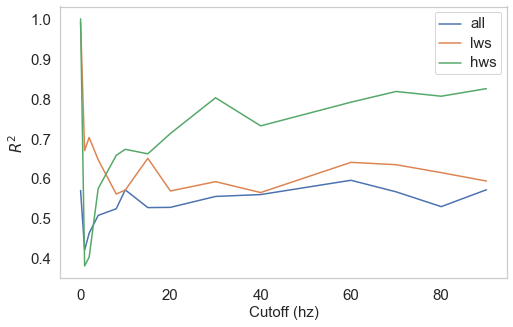

In [86]:
f,ax=plt.subplots(1,1,figsize=(8,5))
ax.set_xlabel('Cutoff (hz)')
ax.set_ylabel('$R^2$')
ax.plot(rsquared_df.cf,rsquared_df.all_df,label='all')
ax.plot(rsquared_df.cf,rsquared_df.lws,label='lws')
ax.plot(rsquared_df.cf,rsquared_df.hws,label='hws')
ax.grid(False)
ax.legend()
figurefirst.mpl_functions.set_fontsize(f, 15)


In [82]:
# rsquared_df.to_hdf(dir+'lpf_rsquared.h5', key='rsquared_df', mode='w')